# Machine learning: Decision Tree

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from pickle import dump
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx",
]
TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx",
]
TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

In [3]:
results = []
models=[]

for index, dataset in enumerate(TRAIN_DATASETS):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(dataset, y_train)
    models.append(model)
    
    y_pred_train = model.predict(dataset)
    y_pred_test = model.predict(TEST_DATASETS[index])

    results.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )

results

[{'train': 1.0, 'test': 0.8116883116883117},
 {'train': 1.0, 'test': 0.8311688311688312}]

Hay overfitting en ambos resultados, aunque es mejor el accuracy score del modelo sin outliers.
Vamos a probar las predicciones con la selección de 5 características hecha

## Predicción con feature selection k=5

In [4]:
train_data = pd.read_csv("../data/processed/clean_train_sin_outliers.csv")
test_data = pd.read_csv("../data/processed/clean_test_sin_outliers.csv")

X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

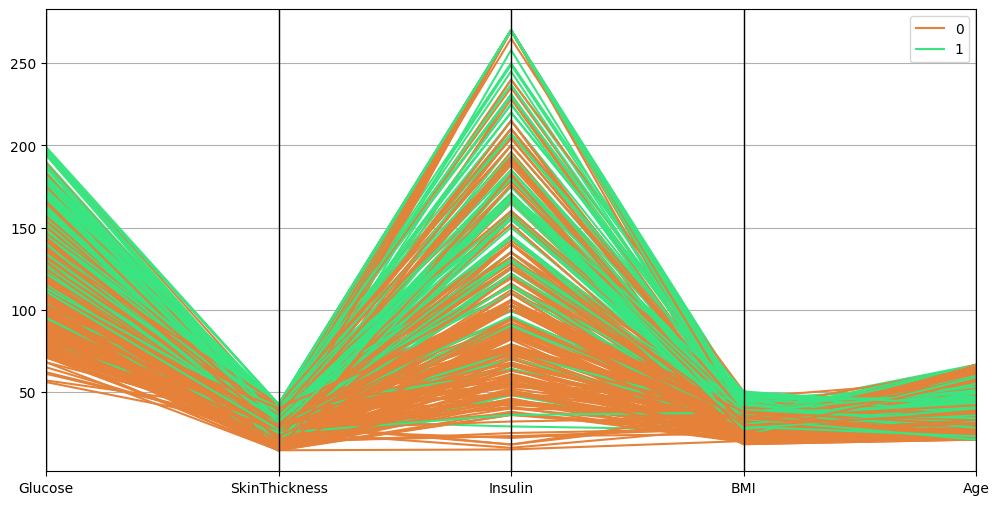

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

pd.plotting.parallel_coordinates(train_data, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))

plt.show()

`SkinThickness` no parece determinante

In [6]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

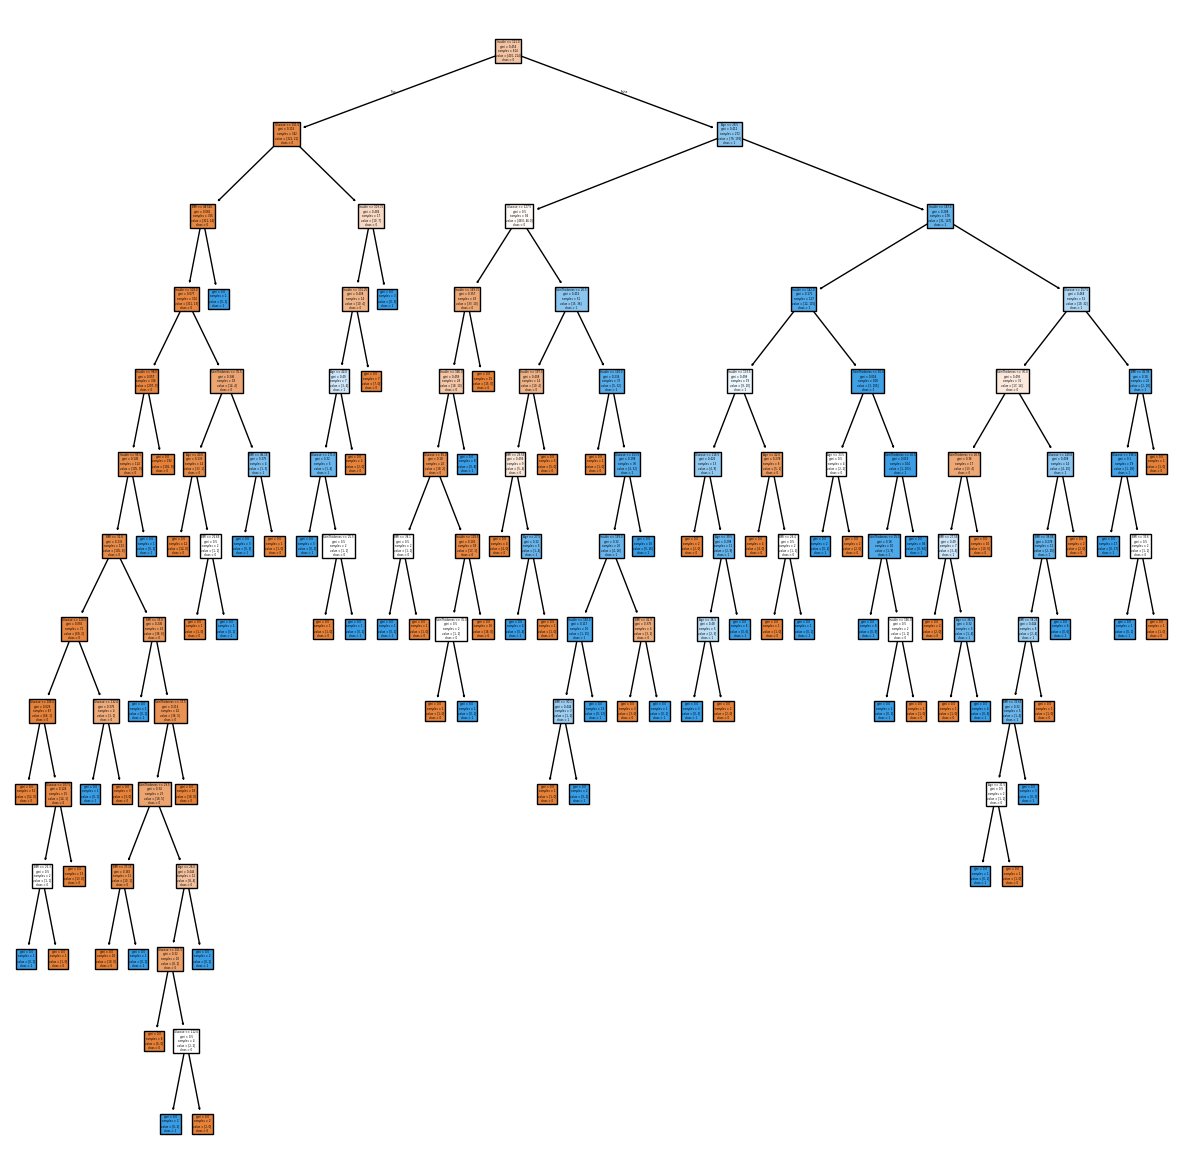

In [7]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [8]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Train: {accuracy_score(y_train, y_pred_train)}")
print(f"Test: {accuracy_score(y_test, y_pred_test)}")

Train: 1.0
Test: 0.8766233766233766


Sigue habiendo overfitting pero mejora el accuracy score de test

## Hiperparametrización

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 6, 7, 8, 10, 15],
    'min_samples_split': [2, 4, 5, 10],
    'min_samples_leaf': [1, 5, 7, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(model, param_grid, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 6, 7, 8, 10, 15],
                         'min_samples_leaf': [1, 5, 7, 10],
                         'min_samples_split': [2, 4, 5, 10]},
             scoring='accuracy')

In [10]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid.best_params_}")

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [11]:
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)

In [12]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Train: {accuracy_score(y_train, y_pred_train)}")
print(f"Test: {accuracy_score(y_test, y_pred_test)}")

Train: 0.9071661237785016
Test: 0.8766233766233766


No mejora el accuracy score de test pero parece que puede prevenir overfitting

In [13]:
results.append(
        {
            "train": accuracy_score(y_test, y_pred_test),
            "test": accuracy_score(y_train, y_pred_train),
            "best_params": grid.best_params_
        }
)

## Guardado del modelo

In [14]:
dump(model, open("../models/decision_tree_classifier_k5_sin_outliers_42.sav", "wb"))

## Guardado de los resultados

In [15]:
with open("../models/final_results.json", "w") as f:
    json.dump(results, f, indent=4)